# Supernova neutrino flux 
This notebook demonstrates using a simple model to showcase the cooling of a neutron star via neutrinos. 

## Importing libraries 

First, we check for the necessary libraries and download them:

In [30]:
import sys, subprocess, pkg_resources
required = {'numpy','wnutils','matplotlib', 'gslconsts', 'scipy', 'ipywidgets'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from gslconsts.consts import *
import wnutils.xml as wx
import io, requests
from ipywidgets import interact, interactive
from scipy.integrate import quad
import ipywidgets as widgets

The gslconsts package allows for us to define any fundamental constant. Here we define Planck's constant, the speed of light, and Boltzmann's constant in CGS.

In [32]:
h = GSL_CONST_CGS_PLANCKS_CONSTANT_H
c = GSL_CONST_CGS_SPEED_OF_LIGHT
k = GSL_CONST_CGS_BOLTZMANN

## Neutrino Flux 

Neutrinos play an important role in cooling the newly formed neutron star in CCSN, heating the supernova shock, and explosive nucleosynthesis. Following core collapse, the recently formed neutron star which begins at a radius on the order of 100km, is cooled from neutrino emission. In the next 10 seconds neutrinos will carry away 10$^{53}$ ergs of energy, 10$^{51}$ of which will go into energizing the stalled shock wave. The following notebook will aim to provide a simple model of the neutrino emission of a nascent neutron star by considering a thermal distribution. The shortcomings of this model will be commented on at the end. 

Neutrino emission is different from photon emission since neutrons are fermions and thus are governed by Fermi-Dirac statistics following from the Pauli exclusion principle. The intensity of the emitted neutrinos (assuming thermal emission which is reasonable for temperatures greater than 10 MeV) is:

\begin{gather}
I_\nu = \frac{2h\nu^3/c^2}{e^{(h\nu-\mu)/kT}+1}\notag
\end{gather}

Where $\mu$ here is the chemical potential. This can also be written in terms of neutrino energies:

\begin{gather}
I_E = \frac{2E^3}{h^2c^2} \frac{1}{e^{(E - \mu)/kT} + 1}\notag
\end{gather}

We can then plot the intensity vs. neutrino energy for different chemical potentials. The widget above the graph controls the chemical potential which changes by factors on the order of $k_bT$:

In [33]:
def I(E, mu, T):
    return (2*E**3/(h**2*c**2))/(np.exp((E - mu) / (k*T))+1) 

E = np.logspace(-10,-3,1000) #here in ergs

isotherms = [1e11,2e11,3e11,4e11,5e11,6e11,7e11,8e11,9e11,1e12]

#plot the spectrum
def f(mu):
    fig, ax = plt.subplots()
    for T in isotherms:
        T_MeV = T/(1e10)
        ax.plot(E, I(E,mu,T), label = f'$T$={T_MeV} MeV')
    ax.set_xlabel(r'$E_\nu$ (ergs)')
    ax.set_ylabel(r'$I_\nu$ (ergs cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e10,1e21])
    ax.set_xlim([1e-7,1e-3])
    ax.legend()
    plt.show()
    
interact(f,mu = widgets.BoundedFloatText(value=0, min=-10*k*1e11, max = 10*k*1e11, step= k*1e11 / 3, descriptions='Chemical potential',
                                                      ))

interactive(children=(BoundedFloatText(value=0.0, description='mu', max=0.00013806504, min=-0.00013806504, ste…

<function __main__.f(mu)>

A particularly interesting aspect of this graph is that the intensity is no longer a monotonic function of temperature for large chemical potentials.

We'd like to compare this intensity to the Planck function:

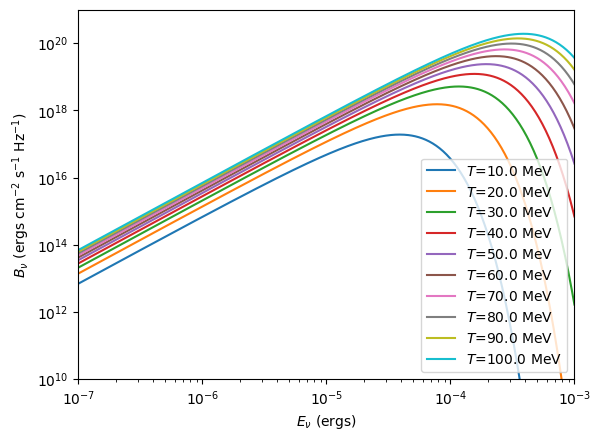

In [34]:
def B(E, T):
    return (2*E**3/(h**2*c**2))/(np.exp((E) / (k*T))-1) 

#plot the spectrum
fig, ax = plt.subplots()
for T in isotherms:
    T_MeV = T/(1e10)
    ax.plot(E, B(E, T), label = f'$T$={T_MeV} MeV')
ax.set_xlabel(r'$E_\nu$ (ergs)')
ax.set_ylabel(r'$B_\nu$ (ergs cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e10,1e21])
ax.set_xlim([1e-7,1e-3])
ax.legend()
plt.show()

We note here that for high frequencies/energies and $\mu$=0, the two plots agree because the exponential is so large that the difference in the denomanator of the Planck vs Fermi distributions will not matter. On the other hand as frequency drops the intentisities begin to differ significantly, with the neutrino intensity dying out much faster for small energy. 

This can be seen clearly by comparing the intensities of photons and neutrinos for the same temperature:

In [35]:
def f(mu):
    fig, ax = plt.subplots()
    ax.plot(E, B(E,isotherms[9]), label = 'Planck')
    ax.plot(E, I(E,mu,isotherms[9]), label = 'Neutrino')
    ax.set_xlabel(r'$E$ (ergs)')
    ax.set_ylabel(r'$B_\nu$ (ergs cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
    T_MeV = isotherms[9]/(1e10)
    ax.set_title(f'$T$={T_MeV} MeV')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e10,1e21])
    ax.set_xlim([1e-7,1e-3])
    ax.legend()
    plt.show()

interact(f,mu = widgets.BoundedFloatText(value=0, min=-5*k*1e11, max = 5*k*1e11, step= k*1e11 / 3, descriptions='Chemical potential',
                                                      ))             

interactive(children=(BoundedFloatText(value=0.0, description='mu', max=6.903252e-05, min=-6.903252e-05, step=…

<function __main__.f(mu)>

Now, the flux for an isotropic emitter as a function of radius is:
\begin{gather}
F = \pi B (R/r)^2 \notag
\end{gather}
where B is the brightness (intensity integrated over all frequencies), R is the radius of the emitter (here a neutron star), and r is the radius of the observer. Where we can obtain the brightness with the simple relationship:
\begin{gather}
B = \int I_\nu d\nu = \int_0^\infty \frac{2h\nu^3}{c^2} \frac{1}{e^{(h\nu-\mu)/kT}+1} d\nu \notag
\end{gather}

or alternatively to integrate over neutrino energies we make the substitution $E=h\nu$:
\begin{gather}
B = \int_0^\infty \frac{2E^3}{h^3c^2} \frac{1}{e^{(E-\mu)/kT}+1} dE \notag
\end{gather}
which needs to be solved numerically with the following function: 

In [36]:
def brightness(mu, T):
    def integrand(E, mu, T):
        return 2 * E**3 / (h**3 * (c*1e-5)**2) * (1 / (np.exp((E-mu) / (k * T)) + 1))

    # Limits of integration
    lower_limit = 0
    upper_limit = 9e-3 # Use np.inf for infinity
    # Numerical integration
    result, error = quad(integrand, lower_limit, upper_limit, args=(mu, T))
    return result

Now that we have the brightness of the neutrinos coming from our neutron star, we can plot the flux of neutrinos as a function of radius. The following plot is interactive, and allows for the input of different neutron star radii and temperatures. 

In [37]:
def F(R, mu, T):
    r = np.linspace(R, 1.2e4, 1000)
    bright = brightness(mu, T)
    return r, np.pi * bright * (R/r)**2

def f(R_ns, T_MeV, mu):
    '''Function for interactive plot'''
    T_ns = T_MeV * 1e10
    r_list, nu_flux = F(R_ns, mu, T_ns)
    fig, ax = plt.subplots()
    ax.plot(r_list, nu_flux)
    ax.set_title(f'Neutrino flux as a function of radius at T={T_MeV} MeV')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel('Flux (ergs s$^{-1}$ km$^{-2}$)')
    plt.show()


interact(f,T_MeV = widgets.BoundedFloatText(value=10, min=10, max = 100, step=10, descriptions='T_ns(K)', disabled=False),
            R_ns = widgets.BoundedFloatText(value = 1e1 , min=1e1,max=1e2,step = 1e1, descriptions ='R_ns(cm)', disabled=False ),
            mu = widgets.BoundedFloatText(value = 0, min = -k*1e11, max = k*1e11, step = k*1e11/3, descriptions = 'Chem potential'))

interactive(children=(BoundedFloatText(value=10.0, description='R_ns', min=10.0, step=10.0), BoundedFloatText(…

<function __main__.f(R_ns, T_MeV, mu)>

To verify this result we calculate the neutrino luminosity and compare it to the realistic value of $1.67\times 10^{52}$:

In [38]:
def L(R, mu, T):
    bright = brightness(mu, T)
    return np.pi * bright * (4* np.pi * R**2)

R_ns = 100
T_MeV = 10
kT = k*T_MeV
mu = kT
def f(T_MeV, R_ns, mu):
    print('The neutrino luminosity at R={:.1f}km, T = {} MeV, and mu = {:.1e}kT is:'.format(R_ns,T_MeV,mu/(k*T_MeV*1e10)), f'{L(R_ns, mu, T_MeV*1e10):.1e}')

interact(f,T_MeV = widgets.BoundedFloatText(value=10, min=10, max = 100, step=10, descriptions='T_ns(K)', disabled=False),
            R_ns = widgets.BoundedFloatText(value = 1e1 , min=1e1,max=1e2,step = 1e1, descriptions ='R_ns(cm)', disabled=False ),
            mu = widgets.BoundedFloatText(value = 0, min = -k*1e11, max = k*1e11, step = (k*1e11)/3, descriptions = 'Chem potential'))

interactive(children=(BoundedFloatText(value=10.0, description='T_MeV', min=10.0, step=10.0), BoundedFloatText…

<function __main__.f(T_MeV, R_ns, mu)>

Then considering a cooling time of 10 seconds we see that the total energy radiated away is on the order of $10^{53}$ ergs.

## Neutrino interaction rate

We now aim to create a simple model for the neutrino interactions as a function of radius. We have obtained the flux which is energy per area per second. If we divide this by the average neutrino energy $<E>$ we get a neutrino number flux which we will call $\Phi$: 

\begin{gather}
\Phi = \frac{F}{<E>} \notag
\end{gather}

We can calculate this using an average neutrino energy of $12\times 10^{-12}$ ergs for electron neutrinos:

In [41]:
def rate(R, T, E, mu):
    radius, flux = F(R, mu, T)
    phi = flux/E 
    return phi, radius

def f(R_ns, T_MeV, mu):
    T_ns = T_MeV*1e10
    fig, ax = plt.subplots()
    E_nu = 12e-12
    phi, radius = rate(R_ns, T_ns, E_nu, mu)
    ax.plot(radius, phi)
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel(r'$\Phi$')
    ax.set_yscale('log')
    plt.show()

interact(f,T_MeV = widgets.BoundedFloatText(value=10, min=10, max = 100, step=10, descriptions='T_ns(K)', disabled=False),
        R_ns = widgets.BoundedFloatText(value = 1e1 , min=1e1,max=1e2,step = 1e1, descriptions ='R_ns(cm)', disabled=False ),
        mu = widgets.BoundedFloatText(value = 0, min = -k*1e10, max = k*1e11, step = k*1e11/3, descriptions = 'Chem potential'))

interactive(children=(BoundedFloatText(value=10.0, description='R_ns', min=10.0, step=10.0), BoundedFloatText(…

<function __main__.f(R_ns, T_MeV, mu)>

Finally then, if we consider the number of neutrino interactions being proportional to the number of neutrinos times the interaction cross section (taken here to be 1 barn = $10^{-24}$ cm$^2$) we can obtain some idea of how the neutrino interactions will go as a function of radius:

In [42]:
def rate(R, T, E, mu):
    radius, flux = F(R, mu, T)
    phi = flux/E 
    return phi, radius

def f(R_ns, T_MeV, mu):
    T_ns = T_MeV*1e10
    fig, ax = plt.subplots()
    E_nu = 12e-12
    phi, radius = rate(R_ns, T_ns, E_nu, mu)
    ax.plot(radius, phi*10**(-24))
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel(r'$\Phi$')
    ax.set_yscale('log')
    plt.show()

interact(f,T_MeV = widgets.BoundedFloatText(value=10, min=10, max = 100, step=10, descriptions='T_ns(K)', disabled=False),
        R_ns = widgets.BoundedFloatText(value = 1e1 , min=1e1,max=1e2,step = 1e1, descriptions ='R_ns(cm)', disabled=False ),
        mu = widgets.BoundedFloatText(value = 0, min = -k*1e10, max = k*1e11, step = k*1e11/3, descriptions = 'Chem potential'))

interactive(children=(BoundedFloatText(value=10.0, description='R_ns', min=10.0, step=10.0), BoundedFloatText(…

<function __main__.f(R_ns, T_MeV, mu)>